# **PRAICP-1002 Traffic Sign Detection**

The Traffic Sign Dataset is a comprehensive collection of road sign images designed for training and testing deep learning models in traffic sign recognition tasks. This dataset contains 39,209 RGB images of various traffic signs, making it suitable for applications such as autonomous driving, intelligent transportation systems, and road safety enhancements.

**Dataset Structure**

The dataset is organized into a hierarchical folder structure:

- The main folder contains 43 subfolders, each named from 0 to 42.
- Each subfolder corresponds to a specific traffic sign class, representing a unique road sign type.

### Import the necessary libraries

In [73]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from tqdm import tqdm
from joblib import Parallel, delayed
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix


### Folder Paths

In [30]:
# Paths
train_folder = "/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection/PRAICP-1002-TrafSignDetc/Train"
labels_csv = "/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection/labels.csv"
test_folder = "/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection/PRAICP-1002-TrafSignDetc/Test"
test_csv_path = '/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection/PRAICP-1002-TrafSignDetc/Test.csv'


### Loading and Processing the Dataset

In [31]:
# Load and Process Dataset
def load_dataset(folder):
    data = [(os.path.join(root, file), int(folder_name))
            for folder_name in os.listdir(folder)
            if os.path.isdir(os.path.join(folder, folder_name))
            for root, _, files in os.walk(os.path.join(folder, folder_name))
            for file in files if file.endswith(('.png', '.jpg', '.jpeg'))]
    return pd.DataFrame(data, columns=["ImagePath", "ClassId"]).sort_values("ClassId").reset_index(drop=True)

df = load_dataset(train_folder)


In [32]:
# Display the first five rows of the DataFrame
df.head()

,ImagePath,ClassId
0,/content/drive/MyDrive/DataMites_AIE_Internshi...,0
1,/content/drive/MyDrive/DataMites_AIE_Internshi...,0
2,/content/drive/MyDrive/DataMites_AIE_Internshi...,0
3,/content/drive/MyDrive/DataMites_AIE_Internshi...,0
4,/content/drive/MyDrive/DataMites_AIE_Internshi...,0


### Adding Labels to each classes

In [33]:
# Load Labels
labels_df = pd.read_csv(labels_csv).rename(columns={"Name": "LabelName"})

# Merge df with labels_df based on 'class_id'
df = df.merge(labels_df, on="ClassId", how="left")

# Display the updated DataFrame
print("\nDataset Samples:")
df.sample(10)


Dataset Samples:


,ImagePath,ClassId,LabelName
22658,/content/drive/MyDrive/DataMites_AIE_Internshi...,14,Stop
29868,/content/drive/MyDrive/DataMites_AIE_Internshi...,25,Road work
19445,/content/drive/MyDrive/DataMites_AIE_Internshi...,12,Priority road
12509,/content/drive/MyDrive/DataMites_AIE_Internshi...,8,Speed limit (120km/h)
11649,/content/drive/MyDrive/DataMites_AIE_Internshi...,7,Speed limit (100km/h)
2789,/content/drive/MyDrive/DataMites_AIE_Internshi...,2,Speed limit (50km/h)
2463,/content/drive/MyDrive/DataMites_AIE_Internshi...,2,Speed limit (50km/h)
37025,/content/drive/MyDrive/DataMites_AIE_Internshi...,38,Keep right
1731,/content/drive/MyDrive/DataMites_AIE_Internshi...,1,Speed limit (30km/h)
29073,/content/drive/MyDrive/DataMites_AIE_Internshi...,25,Road work


In [34]:
# Checking the shape of the dataset
print("Dataset shape:")
df.shape


Dataset shape:


(39209, 3)

*A total of 39,209 RGB images which includes 43 different traffic sign categories*

### Plotting the distribution of each classes

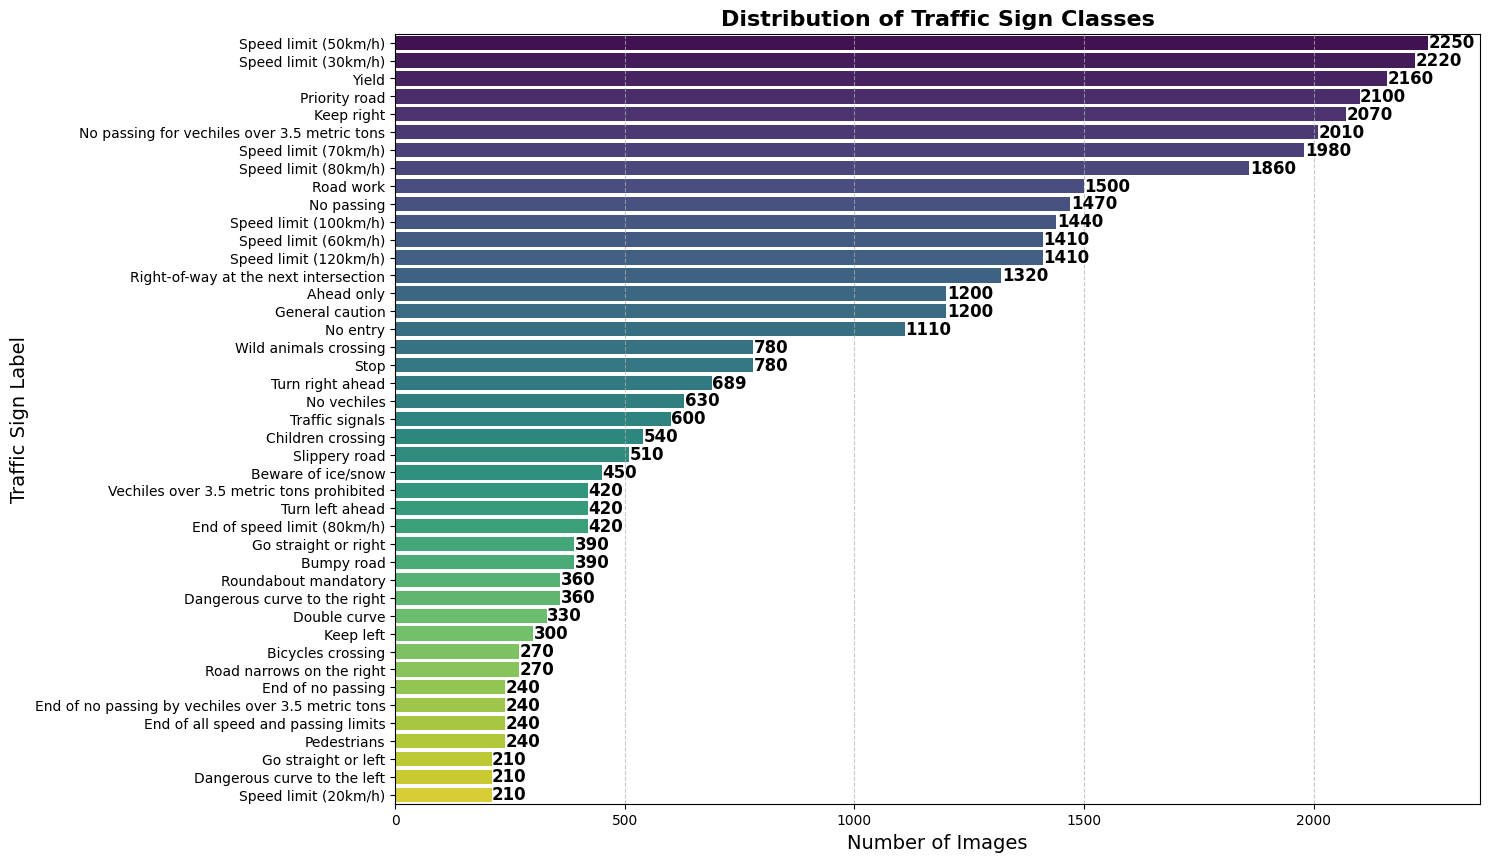

In [35]:
# Prepare data
class_counts = df['LabelName'].value_counts().reset_index()
class_counts.columns = ['LabelName', 'Count']

# Plot
plt.figure(figsize=(14, 10))
ax = sns.barplot(data=class_counts, x='Count', y='LabelName', hue='LabelName', palette="viridis", legend=False)

# Add count annotations
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1,  # Position slightly to the right of the bar
            p.get_y() + p.get_height() / 2,  # Centered vertically
            f"{int(width)}",  # Text (integer count)
            va='center', ha='left', fontsize=12, fontweight='bold')

# Plot customization
plt.xlabel("Number of Images", fontsize=14)
plt.ylabel("Traffic Sign Label", fontsize=14)
plt.title("Distribution of Traffic Sign Classes", fontsize=16, fontweight="bold")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


### Plotting random samples images from the DataFrame with their labels

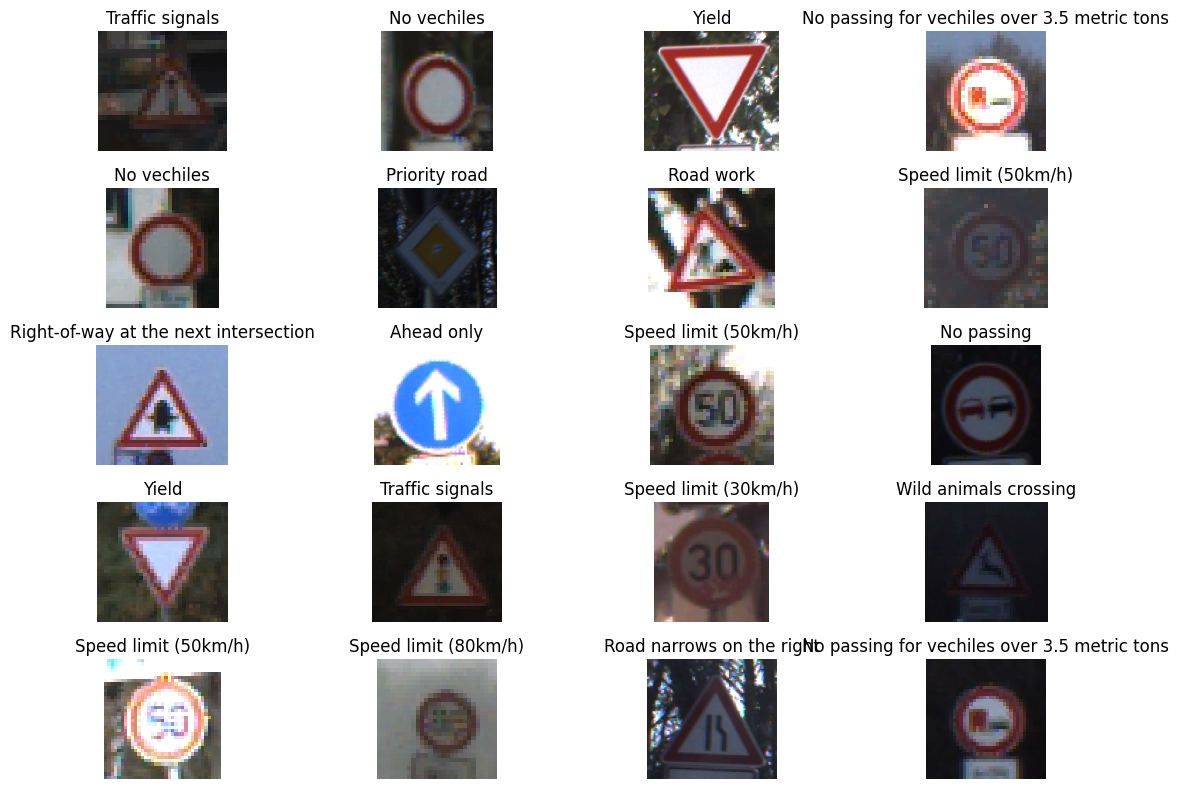

In [36]:
# Number of images to display
num_images = 20
columns = 4  # Number of columns in grid
rows = num_images // columns  # Calculate number of rows

# Select random sample
random_images = df.sample(n=num_images, random_state=42)

# Create figure
plt.figure(figsize=(12, 8))

for i, row in enumerate(random_images.itertuples(), 1):
    img = cv2.imread(row.ImagePath)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

    plt.subplot(rows, columns, i)  # Create subplot
    plt.imshow(img)  # Show image
    plt.title(row.LabelName, fontsize=12)  # Display food class as title
    plt.axis("off")  # Hide axes

plt.tight_layout()  # Adjust layout
plt.show()  # Display all images


### Setting the size of the Images

In [37]:
IMG_SIZE = (32, 32)
NUM_CORES = multiprocessing.cpu_count() # For multi processing

### Splitting the DataFrame into Train and Validation Sets

In [38]:
# Load Images with Parallel Processing
def process_image(path):
    img = cv2.imread(path)
    if img is None: return None
    img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), IMG_SIZE)
    return img.astype(np.float32) / 255.0

def load_images(df):
    images = Parallel(n_jobs=NUM_CORES)(delayed(process_image)(p) for p in tqdm(df["ImagePath"], desc="Loading Images"))
    valid_images = [(img, lbl) for img, lbl in zip(images, df["ClassId"]) if img is not None]
    imgs, labels = zip(*valid_images)
    return np.array(imgs), np.array(labels)


In [39]:
# Train-Validation Split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["ClassId"], random_state=42)
X_train, y_train = load_images(train_df)
X_val, y_val = load_images(val_df)

# Save Datasets
for arr, name in zip([X_train, y_train, X_val, y_val], ["X_train", "y_train", "X_val", "y_val"]):
    np.save(f"/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection/{name}.npy", arr)



Loading Images: 100%|██████████| 7842/7842 [14:33<00:00,  8.98it/s]


*Saving the X_train, Y_train, X_val y_val as .npy file to avoid running again and again as it takes alot of time to process the images*

In [40]:
# Load the saved NumPy arrays
X_train = np.load("/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection/X_train.npy")
y_train = np.load("/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection/y_train.npy")
X_val = np.load("/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection/X_val.npy")
y_val = np.load("/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection/y_val.npy")


*Loading the saved .npy files using np.load command*

In [41]:
# One-Hot Encoding
num_classes = df["ClassId"].nunique()
y_train, y_val = map(lambda y: to_categorical(y, num_classes), [y_train, y_val])

# Verify the shape
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


y_train shape: (31367, 43)
y_val shape: (7842, 43)


*The y_train and y_val contains the unique ClassId is encoded using One Hot Encoding*

### Creating the Test DataFrame from the Test Folder

In [42]:
# Creating the Test DataFrame
test_df = pd.read_csv(test_csv_path, usecols=["ClassId", "Path"])  # Directly select needed columns
test_df["Full_Path"] = test_df["Path"].str.replace(r"^Test/", "", regex=True).apply(lambda x: os.path.join(test_folder, x))

# Merge with labels (ensure labels_df is defined)
test_df = test_df.merge(labels_df, on="ClassId", how="left")

In [43]:
# Processing the test images
def process_test_image(img_path, class_id):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read {img_path}")
        return None
    img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), IMG_SIZE)  # Resize images
    return img.astype(np.float32) / 255.0, class_id  # Normalize images

# Load Test Images with Parallel Processing
def load_test_images(df):
    results = Parallel(n_jobs=NUM_CORES)(
        delayed(process_test_image)(row.Full_Path, row.ClassId) for row in tqdm(df.itertuples(), total=len(df), desc="Processing Test Images")
    )
    valid_results = [res for res in results if res]  # Filter out None values
    return map(np.array, zip(*valid_results)) if valid_results else (np.empty((0, *IMG_SIZE, 3)), np.empty(0))


In [44]:
# Creating X_test, y_test from Test DataFrame and saving as .npy files
X_test, y_test = load_test_images(test_df)

# Save Datasets
save_dir = "/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection"
np.save(f"{save_dir}/X_test.npy", X_test)
np.save(f"{save_dir}/y_test.npy", y_test)
print(f"Saved: X_test shape={X_test.shape}, y_test shape={y_test.shape}")


Processing Test Images: 100%|██████████| 12630/12630 [25:53<00:00,  8.13it/s]


Saved: X_test shape=(12630, 32, 32, 3), y_test shape=(12630,)


*Test DataFrame contains 12630 random traffic sign images*

In [47]:
# Load the saved NumPy arrays
X_test = np.load("/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection/X_test.npy")
y_test = np.load("/content/drive/MyDrive/DataMites_AIE_Internship/Traffic_Sign_Detection/y_test.npy")


*Loading the saved .npy files using np.load command*

In [48]:
# One-Hot Encoding for y_test
y_test = to_categorical(y_test, num_classes=num_classes)

# Verify the shape
print("y_test shape:", y_test.shape)  # Should be (num_samples, num_classes)

y_test shape: (12630, 43)


*Encoding y_test using One Hot Encoding*

### Balancing the Class Imbalance

In [53]:
# Compute class weights

class_weights = dict(
    zip(
        np.unique(y_train_labels),
        compute_class_weight(class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels)
    )
)


*Certain traffic sign classes have significantly more samples than others. To quantify this, the frequency of each class is computed*

### Data Augmentation

In [50]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
    )


# **Model Building**

### 1. Custom CNN Model

In [51]:
# CNN Model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compiling the model
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,284,971 (4.90 MB)

 Trainable params: 1,284,587 (4.90 MB)

 Non-trainable params: 384 (1.50 KB)

In [54]:
# Training the Model
history_cnn = model_cnn.fit(datagen.flow(X_train, y_train, batch_size=32),
                            validation_data=(X_val, y_val),
                            epochs=20,
                            class_weight=class_weights
                            )


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 240s 240ms/step - accuracy: 0.1183 - loss: 4.4951 - val_accuracy: 0.2483 - val_loss: 2.7563
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 226s 230ms/step - accuracy: 0.3526 - loss: 2.0122 - val_accuracy: 0.5047 - val_loss: 1.4949
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 282s 251ms/step - accuracy: 0.4815 - loss: 1.4867 - val_accuracy: 0.5842 - val_loss: 1.2115
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 239s 244ms/step - accuracy: 0.5551 - loss: 1.2230 - val_accuracy: 0.6586 - val_loss: 0.9637
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 234s 239ms/step - accuracy: 0.6131 - loss: 1.0341 - val_accuracy: 0.5815 - val_loss: 1.3194
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 227s 231ms/step - accuracy: 0.6514 - loss: 0.8978 - val_accuracy: 0.7911 - val_loss: 0.5623
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 269s 239ms/step - accuracy: 0.6877 - loss: 0.8256 - val_accuracy: 0.8009 - val_loss: 0.5949
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 252s 229ms/step - accuracy: 0.7167 - loss: 0.72

In [55]:
# Evaluating the model
cnn_loss, cnn_accuracy = model_cnn.evaluate(X_test, y_test)
print(f"CNN Model - Loss: {cnn_loss}, Accuracy: {cnn_accuracy}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.8757 - loss: 0.4287
CNN Model - Loss: 0.4443781077861786, Accuracy: 0.8763262033462524


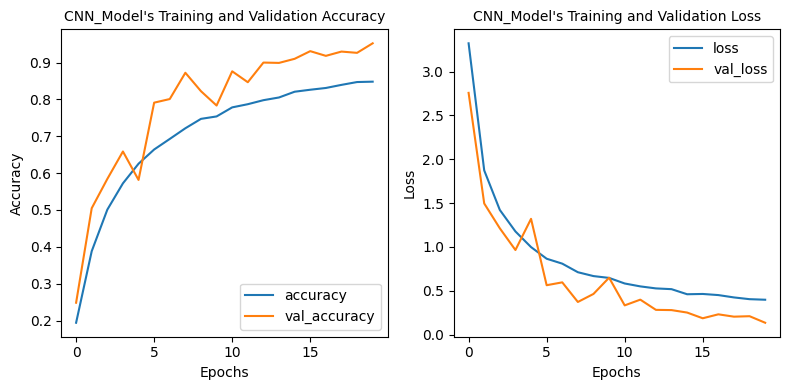

In [56]:
# Custom CNN Accuracy and Loss plot
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("CNN_Model's Training and Validation Accuracy",  fontsize=10)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='loss')
plt.plot(history_cnn.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("CNN_Model's Training and Validation Loss", fontsize=10)
plt.legend()


plt.tight_layout()
plt.show()

In [57]:
# Prediction
y_pred_cnn = np.argmax(model_cnn.predict(X_test), axis=1)


395/395 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step


### Plotting Classification and Confusion Matrics

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.73      0.73      0.73        60
                              Speed limit (30km/h)       0.86      0.86      0.86       720
                              Speed limit (50km/h)       0.75      0.83      0.79       750
                              Speed limit (60km/h)       0.95      0.91      0.93       450
                              Speed limit (70km/h)       0.95      0.92      0.94       660
                              Speed limit (80km/h)       0.86      0.80      0.83       630
                       End of speed limit (80km/h)       0.76      0.95      0.84       150
                             Speed limit (100km/h)       0.87      0.97      0.92       450
                             Speed limit (120km/h)       0.93      0.85      0.89       450
                                        No passing       0.98      0.95      0.

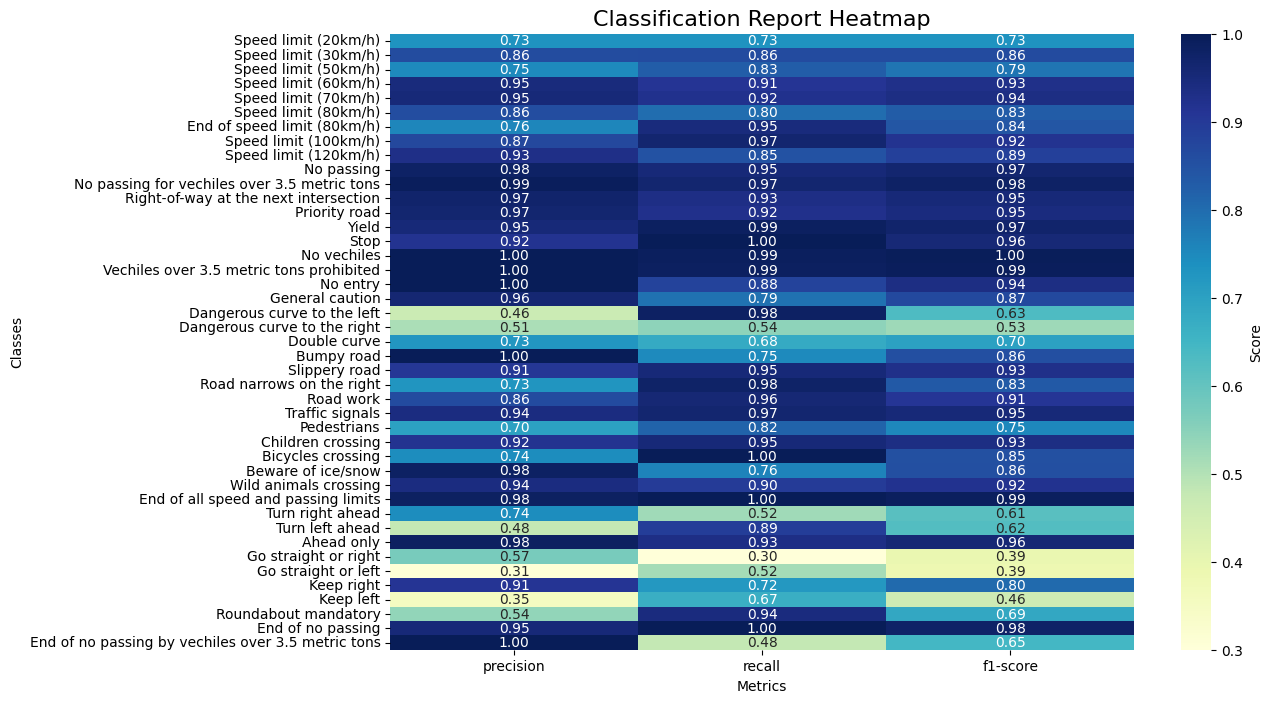

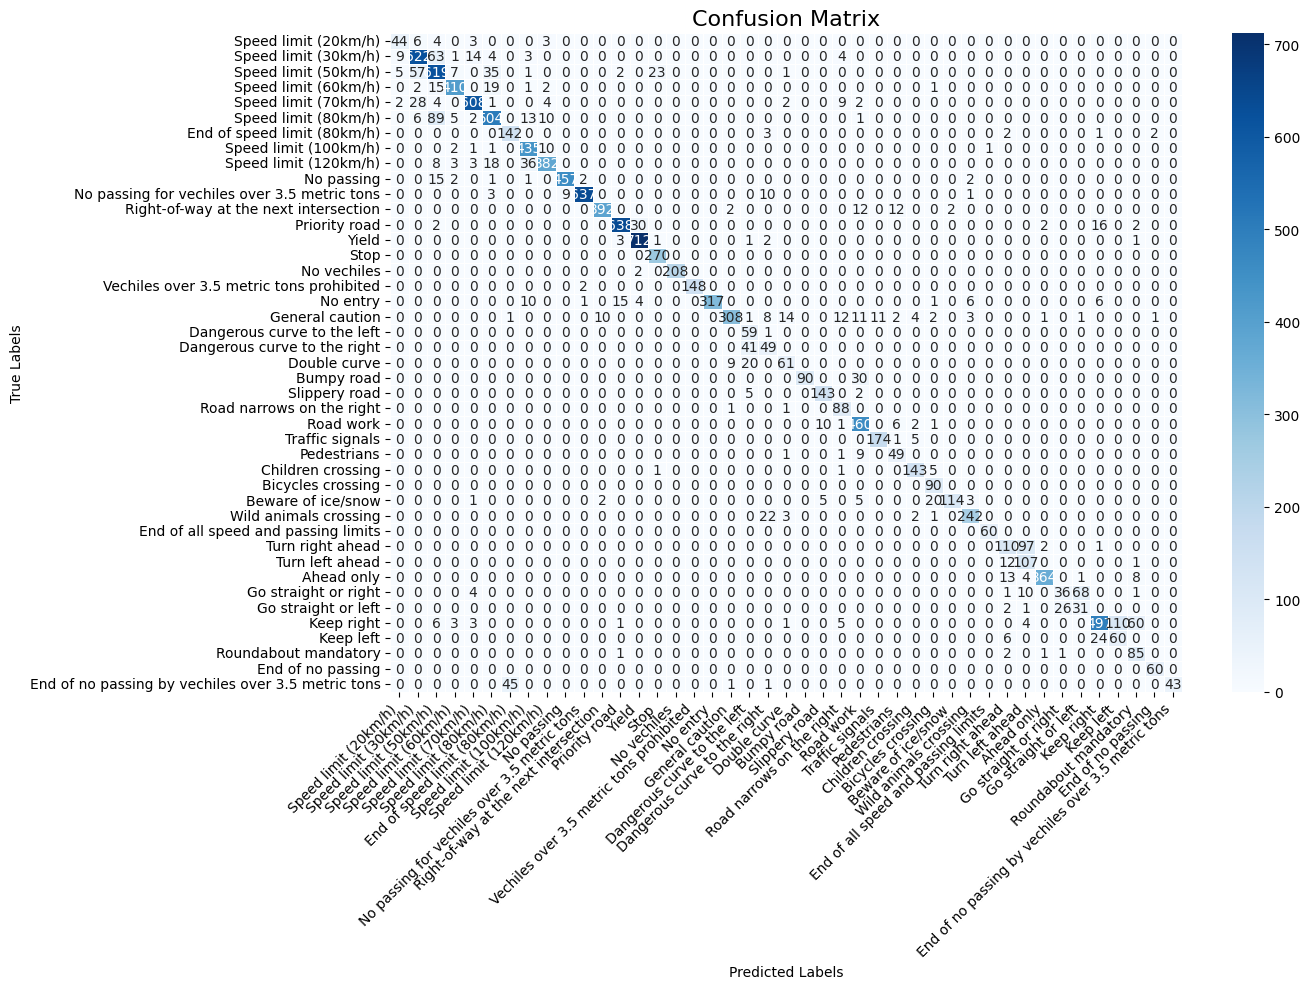

In [61]:
# Convert one-hot encoded y_test to integer labels
y_test_labels = np.argmax(y_test, axis=1)

# Classification Report

report = classification_report(
    y_test_labels, y_pred_cnn, target_names=labels_df.sort_values("ClassId")["LabelName"]
)
print(report)

# Plot classification metrics as heatmap
report_dict = classification_report(
    y_test_labels, y_pred_cnn, target_names=labels_df.sort_values("ClassId")["LabelName"], output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-3, :-1], annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={"label": "Score"})
plt.title("Classification Report Heatmap", fontsize=16)
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()


# Confusion Matrix

cm = confusion_matrix(y_test_labels, y_pred_cnn)
class_names = labels_df.sort_values("ClassId")["LabelName"]

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, linewidths=0.5)
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Predicting Random Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


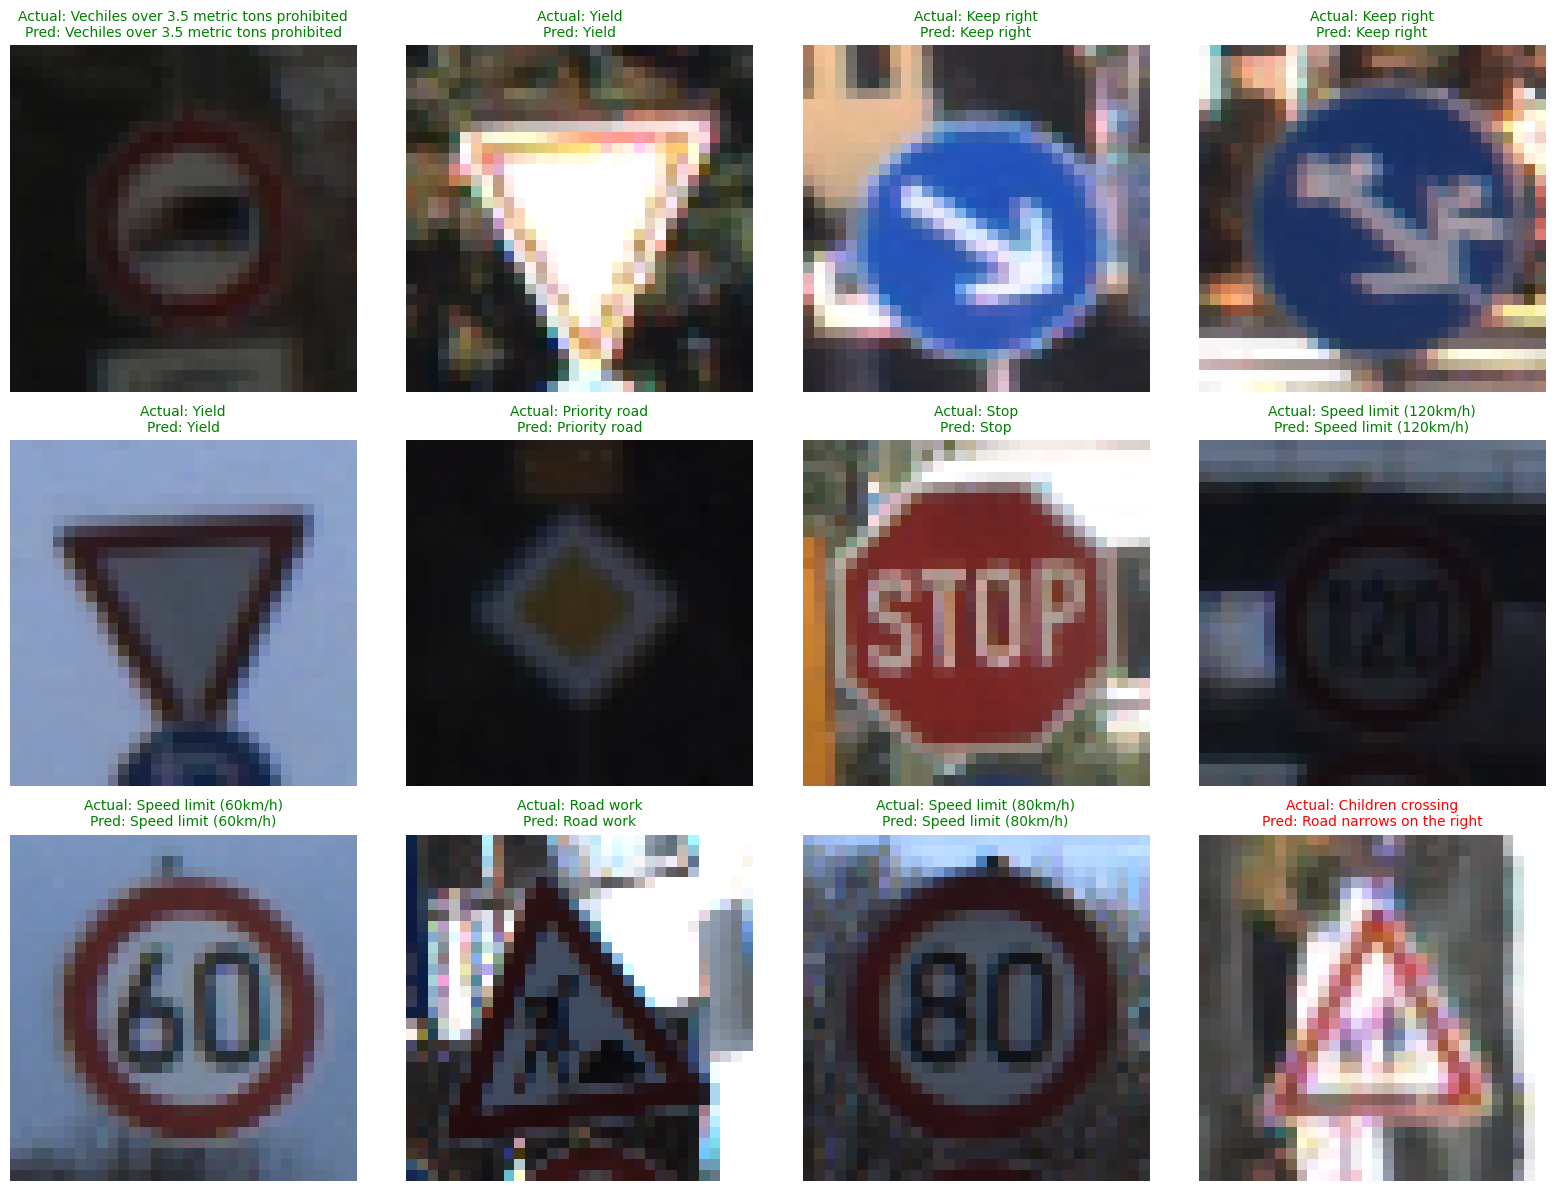

In [63]:
# Select Random Samples

num_images = 12  # Number of images to display
indices = random.sample(range(len(X_test)), num_images)

# Get corresponding images, true labels, and predictions
sample_images = X_test[indices]
true_labels = np.argmax(y_test[indices], axis=1)
pred_labels = np.argmax(model_cnn.predict(sample_images), axis=1)

class_names = labels_df.sort_values("ClassId")["LabelName"].tolist()


# Plot Images with Labels

plt.figure(figsize=(16, 12))
columns = 4

for i, (img, true_label, pred_label) in enumerate(zip(sample_images, true_labels, pred_labels), 1):
    plt.subplot((num_images + columns - 1) // columns, columns, i)
    plt.imshow(img)
    plt.axis('off')

    # Display labels with color indication (green: correct, red: incorrect)
    color = "green" if true_label == pred_label else "red"
    plt.title(
        f"Actual: {class_names[true_label]}\nPred: {class_names[pred_label]}",
        fontsize=10,
        color=color
    )

plt.tight_layout()
plt.show()


### 2. VGG16 MODEL


In [74]:
# VGG16 Model
def build_vgg16_model(input_shape=(32, 32, 3), num_classes=43, learning_rate=0.001):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) # Compiling the Model
    return model

# Build and summarize the VGG16 model
model_vgg = build_vgg16_model(input_shape=(32, 32, 3), num_classes=num_classes)

#Model Summary
model_vgg.summary()


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 14,857,067 (56.68 MB)

 Trainable params: 142,379 (556.17 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [75]:
# Train the model
history_vgg = model_vgg.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 650s 660ms/step - accuracy: 0.1665 - loss: 2.9968 - val_accuracy: 0.3871 - val_loss: 2.0006
Epoch 2/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 594s 606ms/step - accuracy: 0.3303 - loss: 2.0861 - val_accuracy: 0.4253 - val_loss: 1.7918
Epoch 3/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 563s 574ms/step - accuracy: 0.3696 - loss: 1.8808 - val_accuracy: 0.4661 - val_loss: 1.6283
Epoch 4/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 596s 607ms/step - accuracy: 0.4083 - loss: 1.7389 - val_accuracy: 0.4693 - val_loss: 1.5779
Epoch 5/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 597s 609ms/step - accuracy: 0.4339 - loss: 1.6292 - val_accuracy: 0.5054 - val_loss: 1.4935
Epoch 6/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 589s 600ms/step - accuracy: 0.4498 - loss: 1.5711 - val_accuracy: 0.5176 - val_loss: 1.4520
Epoch 7/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 623s 601ms/step - accuracy: 0.4514 - loss: 1.5068 - val_accuracy: 0.5357 - val_loss: 1.3896
Epoch 8/20
981/981 ━━━━━━━━━━━━━━━━━━━━ 613s 625ms/step - accuracy: 0.4679 - loss: 1.46

### 3. ResNet50 Model

In [76]:
# ResNet50 Model
def build_resnet50_model(input_shape=(32, 32, 3), num_classes=43, learning_rate=0.001):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) # Compiling the Model
    return model

# Build and summarize the ResNet50 model
model_resnet = build_resnet50_model(input_shape=(32, 32, 3), num_classes=num_classes)

# Model Summary
model_resnet.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,123,307 (92.02 MB)

 Trainable params: 535,595 (2.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [77]:
# Training the Model
history_resnet50 = model_resnet.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10,
    class_weight=class_weights
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 347s 340ms/step - accuracy: 0.0340 - loss: 3.9192 - val_accuracy: 0.0383 - val_loss: 3.7592
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 339s 345ms/step - accuracy: 0.0159 - loss: 3.7782 - val_accuracy: 0.0476 - val_loss: 3.7598
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 346s 353ms/step - accuracy: 0.0180 - loss: 3.7860 - val_accuracy: 0.0574 - val_loss: 3.7602
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 285s 291ms/step - accuracy: 0.0434 - loss: 3.7561 - val_accuracy: 0.0283 - val_loss: 3.7599
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 230s 234ms/step - accuracy: 0.0306 - loss: 3.7624 - val_accuracy: 0.0536 - val_loss: 3.7597
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 318s 325ms/step - accuracy: 0.0298 - loss: 3.7238 - val_accuracy: 0.0574 - val_loss: 3.7618
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 276s 282ms/step - accuracy: 0.0195 - loss: 3.7786 - val_accuracy: 0.0566 - val_loss: 3.7611
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 229s 234ms/step - accuracy: 0.0251 - loss: 3.75

### 4. DenseNet121 Model

In [78]:

def build_densenet_model(input_shape=(32, 32, 3), num_classes=43, learning_rate=0.001):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the DenseNet121 model
model_densenet = build_densenet_model(input_shape=(32, 32, 3), num_classes=num_classes)
model_densenet.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 38, 38, 3)      │              0 │ input_layer_9[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 8, 8, 64)       │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 8, 8, 64)       │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 128)      │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 128)      │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 128)      │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 32)       │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 8, 8, 96)       │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,310,955 (27.89 MB)

 Trainable params: 273,451 (1.04 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [79]:
# Training the Model
history_densenet = model_densenet.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10,
    class_weight=class_weights
)


Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 368s 343ms/step - accuracy: 0.1698 - loss: 3.0214 - val_accuracy: 0.4240 - val_loss: 1.7795
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 250s 255ms/step - accuracy: 0.3388 - loss: 1.9874 - val_accuracy: 0.4806 - val_loss: 1.5772
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 210s 214ms/step - accuracy: 0.3890 - loss: 1.7959 - val_accuracy: 0.4972 - val_loss: 1.4993
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 209s 213ms/step - accuracy: 0.4099 - loss: 1.6926 - val_accuracy: 0.5207 - val_loss: 1.4220
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 200s 203ms/step - accuracy: 0.4186 - loss: 1.6238 - val_accuracy: 0.5431 - val_loss: 1.3652
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 201s 205ms/step - accuracy: 0.4281 - loss: 1.5781 - val_accuracy: 0.5551 - val_loss: 1.3040
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 205s 209ms/step - accuracy: 0.4425 - loss: 1.5500 - val_accuracy: 0.5510 - val_loss: 1.3029
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 207s 211ms/step - accuracy: 0.4486 -

# **SUMMARY**

**1. Traffic Sign Dataset and Label Names:**

The traffic sign dataset contains images of various traffic signs categorized into multiple classes. Each image is labeled with a ClassId, which corresponds to a specific traffic sign. The dataframe containing the label names is created from labels.csv file that maps each ClassId to its descriptive label (e.g., "Speed limit (50km/h)", "Stop", "Yield"). This mapping is crucial for interpreting model predictions and evaluating the performance.

**2. Loading the Train and Test Images with Processing:**

Training and test images are loaded from designated folders. Each image undergoes preprocessing steps, including:

- Resizing: Images are resized to a standard dimension (e.g., 32x32) for consistency.

- Color Conversion: Images are converted to RGB format to ensure color consistency.

- Normalization: Pixel values are scaled to the [0, 1] range to stabilize training.

- Parallel Processing: Multiprocessing is used to expedite loading, especially with large datasets. The processed images and corresponding labels are saved as NumPy arrays for efficient reuse.

**3. Computation of Weights for Class Imbalance:**

Certain traffic sign classes have significantly more samples than others as seen from the class distribution plot. To quantify this class imbalance, the frequency of each class is computed.

Addressing class imbalance is vital because:

- Models tend to be biased toward majority classes.

- Minority classes may be underrepresented, leading to poor generalization.

- Techniques like class weighting ensure that the model pays adequate attention to underrepresented classes, improving overall robustness.

**4. Data Augmentation:**

Data augmentation artificially expands the training dataset by applying transformations such as:

Rotation, translation, and flipping

This process enhances the model's ability to generalize, making it resilient to variations in traffic sign appearances due to environmental factors like lighting or angle changes.

**5. Model Building:**

Multiple architectures were explored for this projects:

- Custom CNN Model
- VGG16 Model
- ResNet50 Model
- DenseNet

Each model was trained with the processed dataset, using appropriate loss functions and optimizers.

**6. Model Evaluation:**

Model's performance was assessed using:

- Classification Report: Provides metrics like precision, recall, and F1-score for each class, highlighting how well each traffic sign is recognized.

- Confusion Matrix: Offers a visual representation of true vs. predicted labels, revealing which classes are often misclassified.

These evaluations help identify strengths and weaknesses of the models, guiding further improvements.

**7. Result Summarization:**

Among the tested models:

- Custom CNN Model has demonstrated superior performance, particularly in recognizing minority classes with less epochs.

- VGG16 and DenseNet Models has achieved good accuracy but required more computational resources.

- ResNet50 has shown poor performance for the same number of epochs.

Data augmentation and class imbalance handling significantly improved overall performance, with the final models achieving high accuracy and robust generalization across varied traffic sign classes.